In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch torchvision timm tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import timm
from torchvision import transforms
from PIL import Image
import random
import torchvision.transforms as transforms
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import load_model


In [5]:
# Load dataset
dataset_path = "/content/drive/MyDrive/dataset/cleaned_dataset.csv"
df = pd.read_csv(dataset_path)

# Display basic info
print(f"Total images: {len(df)}")

df.head()

Total images: 1626


,image_path,class,class_name
0,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
1,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
2,/content/drive/MyDrive/dataset/thin_films_part...,1,Sickle Cell
3,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
4,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell


<ipython-input-6-5d1323cd19fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["class_name"], palette="viridis")


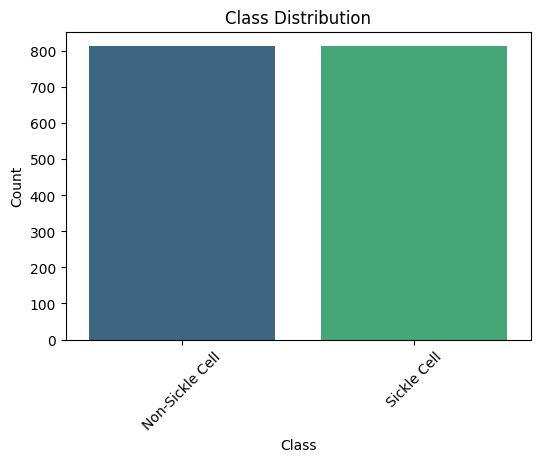

In [6]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["class_name"], palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

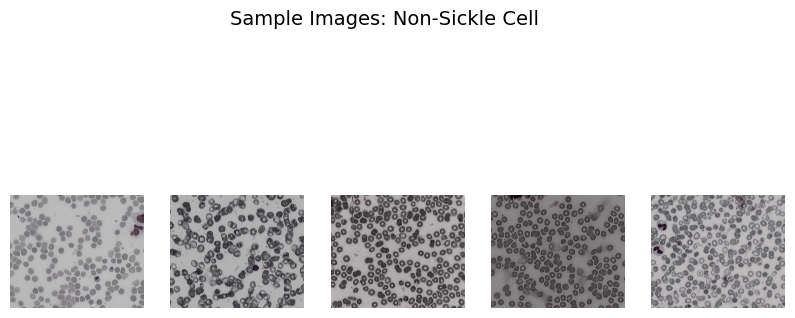

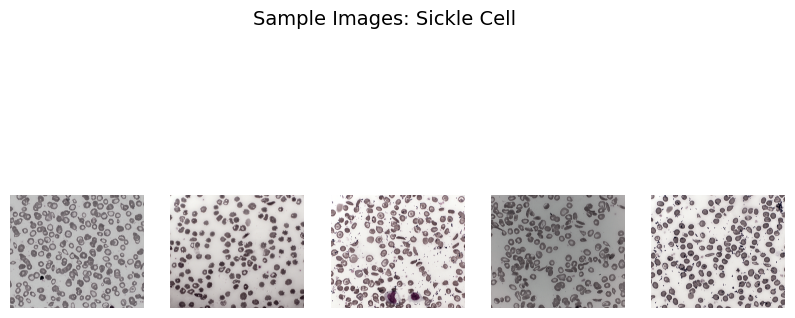

In [7]:
## Display Sample Images
def display_samples(df, class_name, num_samples=5):
    sample_images = df.sample(n=num_samples, random_state=42)["image_path"].tolist()
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Sample Images: {class_name}", fontsize=14)
    plt.show()

# Display separate samples for each class
display_samples(df[df["class"] == 0], "Non-Sickle Cell")
display_samples(df[df["class"] == 1], "Sickle Cell")

In [8]:
# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['class'], random_state=42)

# Convert class column to string
train_df["class"] = train_df["class"].astype(str)
val_df["class"] = val_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)

# Load images using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 1170 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
Found 326 validated image filenames belonging to 2 classes.


In [9]:
print(f"Total dataset size: {len(df)}")
print(f"Train size: {len(train_df)} ({len(train_df) / len(df) * 100:.2f}%)")
print(f"Validation size: {len(val_df)} ({len(val_df) / len(df) * 100:.2f}%)")
print(f"Test size: {len(test_df)} ({len(test_df) / len(df) * 100:.2f}%)")

Total dataset size: 1626
Train size: 1170 (71.96%)
Validation size: 130 (8.00%)
Test size: 326 (20.05%)


In [10]:
# Load Swin Transformer Model (PyTorch)
selected_model = "swin_tiny_patch4_window7_224"
swin_model = timm.create_model(selected_model, pretrained=True, num_classes=0)
swin_model.eval()

# Image Preprocessing for Swin Transformer
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Function to extract features from Swin Transformer
def extract_features(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = swin_model(img)  # Extract features
    return features.numpy()

# Extract features for dataset
X_train = np.array([extract_features(img) for img in train_generator.filepaths])
y_train = train_generator.classes

X_val = np.array([extract_features(img) for img in val_generator.filepaths])
y_val = val_generator.classes

X_test = np.array([extract_features(img) for img in test_generator.filepaths])
y_test = test_generator.classes



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [11]:
# Build TensorFlow Model for Classification
input_layer = Input(shape=(768,))  # Swin-Tiny outputs 768 features
x = Dense(512, activation="relu")(input_layer)
x = Dense(1, activation="sigmoid")(x)  # Binary classification
model = Model(inputs=input_layer, outputs=x)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,241 (1.50 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Convert feature arrays to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convert labels to float32 and check shape
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

X_train = np.squeeze(X_train, axis=1)
X_val = np.squeeze(X_val, axis=1)
X_test = np.squeeze(X_test, axis=1)


print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")  # (1170, 768), float32
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")  # (1170,), float32

X_train shape: (1170, 768), dtype: float32
y_train shape: (1170,), dtype: float32


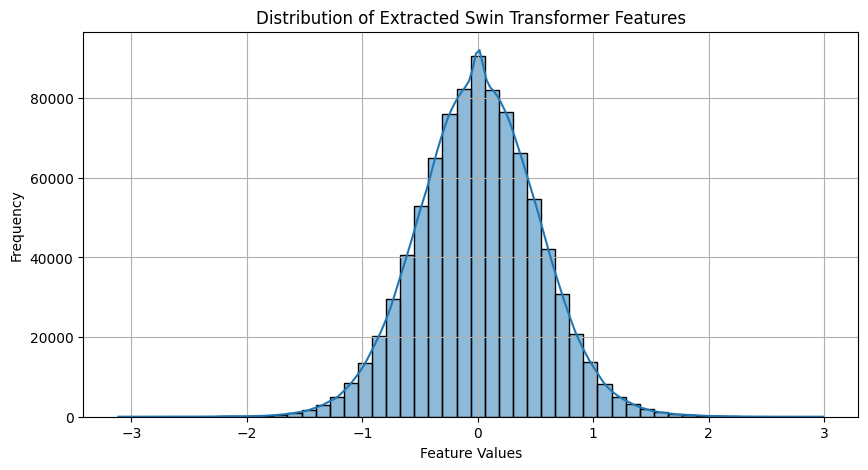

In [19]:
# Visualizing the distribution of extracted features
plt.figure(figsize=(10, 5))
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title("Distribution of Extracted Swin Transformer Features")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [13]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6260 - loss: 0.6468 - val_accuracy: 0.8231 - val_loss: 0.4215
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8168 - loss: 0.4320 - val_accuracy: 0.8385 - val_loss: 0.3831
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8055 - loss: 0.4081 - val_accuracy: 0.8462 - val_loss: 0.3473
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8148 - loss: 0.3716 - val_accuracy: 0.8538 - val_loss: 0.3414
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8621 - loss: 0.3317 - val_accuracy: 0.8692 - val_loss: 0.3164
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8621 - loss: 0.3247 - val_accuracy: 0.8846 - val_loss: 0.3026
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8851 - loss: 0.2897 - val_accuracy: 0.8769 - val_loss: 0.3011
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9063 - loss: 0.2589 - val_accuracy: 0.9000 - v

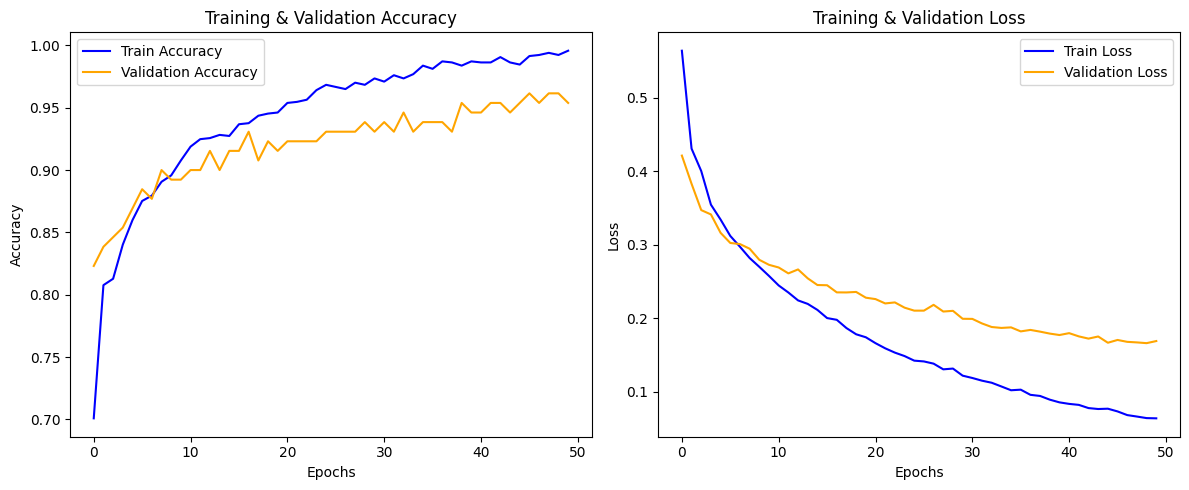

In [16]:
# Plot Training History: Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.4f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9144 - loss: 0.1731 
Test Accuracy: 93.5583%


In [24]:
# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.4f}%")
print(f"Precision: {precision*100:.4f}%")
print(f"Recall: {recall*100:.4f}%")
print(f"F1 Score: {f1*100:.4f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 93.5583%
Precision: 92.2619%
Recall: 95.0920%
F1 Score: 93.6556%


In [25]:
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Non-Sickle", "Sickle"]))

Classification Report:

              precision    recall  f1-score   support

  Non-Sickle       0.95      0.92      0.93       163
      Sickle       0.92      0.95      0.94       163

    accuracy                           0.94       326
   macro avg       0.94      0.94      0.94       326
weighted avg       0.94      0.94      0.94       326



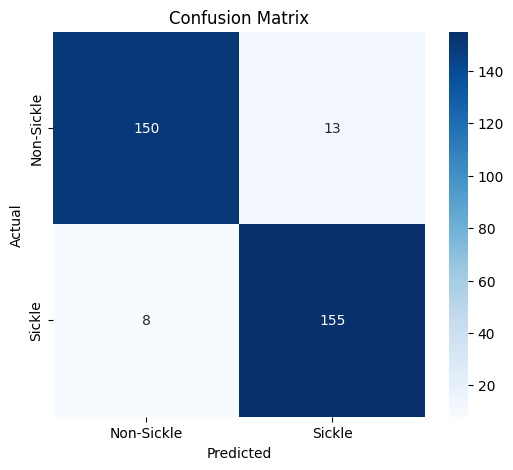

In [26]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Sickle", "Sickle"], yticklabels=["Non-Sickle", "Sickle"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

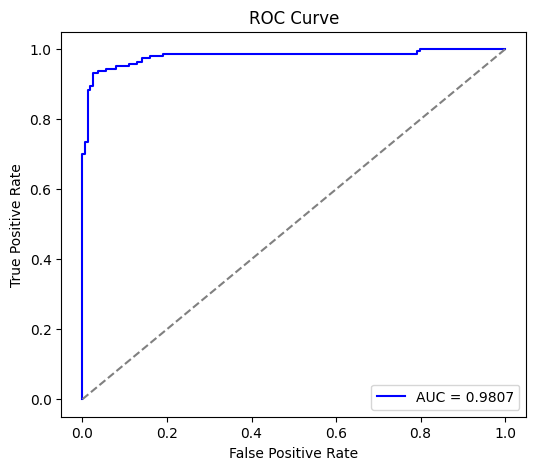

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

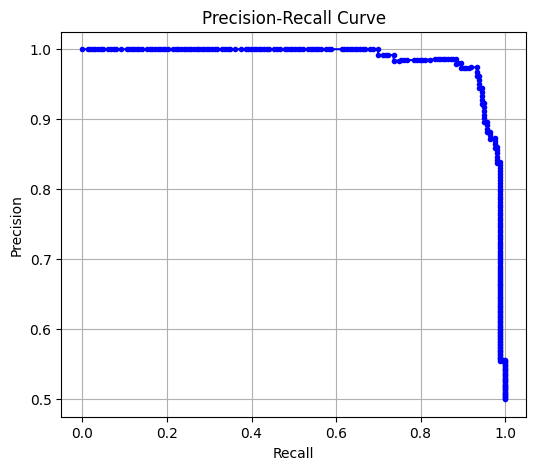

In [28]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


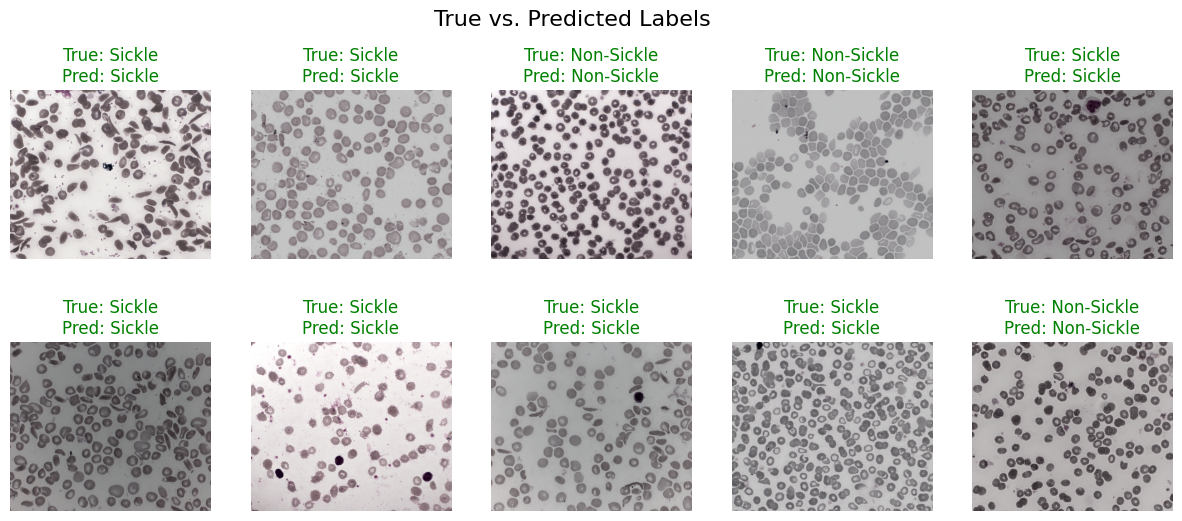

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2  # For reading original images

# Assuming you have test image paths stored in `test_image_paths`
test_image_paths = list(test_df["image_path"])  # Replace with actual DataFrame column

# Select a few random test images
num_images = 10
random_indices = random.sample(range(len(X_test)), num_images)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)

    # Load the original image
    img_path = test_image_paths[idx]
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Get true label
    true_label = "Sickle" if y_test[idx] == 1 else "Non-Sickle"

    # Predict using the extracted feature vector
    pred_prob = model.predict(X_test[idx].reshape(1, -1))  # Reshape for model
    pred_label = "Sickle" if pred_prob > 0.5 else "Non-Sickle"

    # Show image
    plt.imshow(img)
    plt.axis("off")

    # Title with color coding (green = correct, red = incorrect)
    color = "green" if y_test[idx] == (pred_prob > 0.5) else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.suptitle("True vs. Predicted Labels", fontsize=16)
plt.show()


In [32]:
model.save("/content/drive/MyDrive/swin_classifier.h5")  # Save as HDF5 file

In [33]:
# Load the trained model
model = load_model("/content/drive/MyDrive/swin_classifier.h5")

In [34]:
# Load Swin Transformer model (feature extractor)
swin_model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0)
swin_model.eval()  # Set to evaluation mode

# Image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize([0.5], [0.5])  # Normalize
    ])

    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Add batch dimension
    return img

# Extract Swin Transformer features
def extract_features(image_path):
    img_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = swin_model(img_tensor)  # Extract features
    return features.numpy().astype(np.float32)  # Convert to float32 for TensorFlow



In [35]:
df.head(20)

,image_path,class,class_name
0,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
1,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
2,/content/drive/MyDrive/dataset/thin_films_part...,1,Sickle Cell
3,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
4,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
5,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
6,/content/drive/MyDrive/dataset/thin_films_part...,1,Sickle Cell
7,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
8,/content/drive/MyDrive/dataset/thin_films_part...,0,Non-Sickle Cell
9,/content/drive/MyDrive/dataset/thin_films_part...,1,Sickle Cell


In [36]:
# Load new image and extract features
image_path = "/content/drive/MyDrive/dataset/thin_films_part2/sickle-edofed/150218-01-S-A-S1-20190424164843/FieldPos191_EDOF_RGB.tiff"  # Replace with your image path
features = extract_features(image_path)

# Predict using the trained model
prediction = model.predict(features)

# Convert prediction to class (0 = Non-Sickle Cell, 1 = Sickle Cell)
predicted_class = int(prediction[0] > 0.5)  # Binary classification threshold
class_names = ["Non-Sickle Cell", "Sickle Cell"]

print(f"Predicted Class: {class_names[predicted_class]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Class: Sickle Cell



<ipython-input-36-fb3be10fe457>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction[0] > 0.5)  # Binary classification threshold


In [37]:
# Load new image and extract features
image_path = "/content/drive/MyDrive/dataset/thin_films_part2/sickle-edofed/270219-12-S-A-S1-20190816133355/FieldPos451_EDOF_RGB.tiff"  # Replace with your image path
features = extract_features(image_path)

# Predict using the trained model
prediction = model.predict(features)

# Convert prediction to class (0 = Non-Sickle Cell, 1 = Sickle Cell)
predicted_class = int(prediction[0] > 0.5)  # Binary classification threshold
class_names = ["Non-Sickle Cell", "Sickle Cell"]

print(f"Predicted Class: {class_names[predicted_class]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class: Non-Sickle Cell



<ipython-input-37-dafefc9f60b1>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction[0] > 0.5)  # Binary classification threshold
